# Error Analysis

For the undamped string solution, we compiled two different types of error convergence plots: spatial cpnvergence and temporal convergence. Since our IBVP can be measured in both space and time, both of these parameters must be analyzed to ensure the accuracy of our method. 

### Spatial Convergence

We will analyze the spatial convergence first. Our choice of numerical integration method is the Newmark-$\beta$ method. We chose the following parameters:
\
\
$\beta = \frac{1}{4},$
$\gamma = \frac{1}{2},$
\
\
which ensures second-order accuracy and stability in our system, which is ideal for our wave equation.

    dx        error
1.9608e-02  6.9945e-04
9.9010e-03  4.8171e-04
4.9751e-03  2.8425e-04
2.4938e-03  1.5261e-04
1.2484e-03  7.8620e-05
6.2461e-04  3.9835e-05


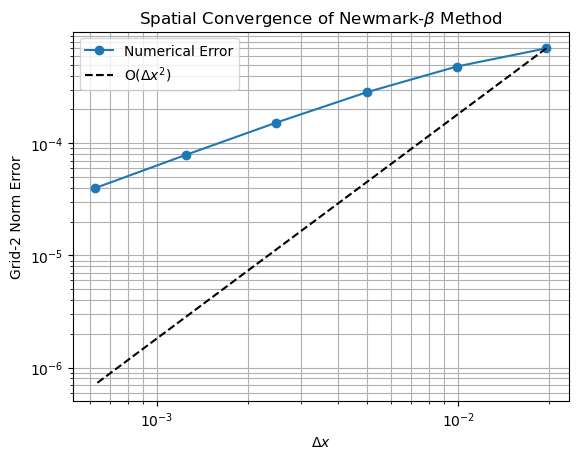

In [17]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import solve_banded

# Define physical and convergence parameters
L = 1.0
c = 1.0
t_final = 0.5

# Exact solution (matching initial amplitude of 0.03 m)
def exact_solution(x, t):
    return 0.03 * np.sin(np.pi * x / L) * np.cos(np.pi * c * t / L)

# Newmark-beta parameters
beta = 1/4
gamma = 1/2

# Grid sizes to test
Ns = [50, 100, 200, 400, 800, 1600]
dXs, errors = [], []

for n in Ns:
    # Build grid and operators
    x = np.linspace(0, L, n + 2)
    dx = x[1] - x[0]
    dXs.append(dx)
    
    # Time step tied to dx
    dt = 0.25 * dx
    Nt = int(t_final / dt)
    
    # Build banded representation of (I - beta dt^2 D2)
    factor = beta * dt**2 * (c**2 / dx**2)
    ab = np.zeros((3, n + 2))
    ab[1, :]    = 1 + 2 * factor      # diagonal
    ab[0, 1:]   = -factor             # superdiagonal
    ab[2, :-1]  = -factor             # subdiagonal
    
    # Prepare solution arrays for two time levels
    u = np.zeros((2, n + 2))
    v = np.zeros((2, n + 2))
    a = np.zeros((2, n + 2))
    
    # Initial conditions
    u[0] = 0.03 * np.sin(np.pi * x / L)
    v[0] = 0.0
    a[0, 1:-1] = (c**2 / dx**2) * (u[0, 2:] - 2 * u[0, 1:-1] + u[0, :-2])
    
    # Time-stepping
    for k in range(Nt):
        rhs     = u[0] + dt * v[0] + 0.5 * dt**2 * a[0]
        u[1]    = solve_banded((1, 1), ab, rhs)
        a[1, 1:-1] = (c**2 / dx**2) * (u[1, 2:] - 2 * u[1, 1:-1] + u[1, :-2])
        v[1]    = v[0] + 0.5 * dt * (a[0] + a[1])
        u[0], u[1] = u[1], u[0]
        v[0], v[1] = v[1], v[0]
        a[0], a[1] = a[1], a[0]
    
    # Compute error at final time
    u_num = u[0]
    u_ex  = exact_solution(x, t_final)
    e_vec = u_num[1:-1] - u_ex[1:-1]
    errors.append(np.linalg.norm(e_vec) / np.sqrt(n))

# Print errors vs dx
print("    dx        error")
for dx, err in zip(dXs, errors):
    print(f"{dx:.4e}  {err:.4e}")

# Plot spatial convergence: error vs dx
plt.figure()
plt.loglog(dXs, errors, 'o-', label='Numerical Error')
ref = errors[0] * (np.array(dXs) / dXs[0])**2
plt.loglog(dXs, ref, 'k--', label='O($Δx^2$)')
plt.xlabel('$Δx$')
plt.ylabel('Grid-2 Norm Error')
plt.title('Spatial Convergence of Newmark-$\\beta$ Method')
plt.grid(True, which='both')
plt.legend()
plt.show()

Upon futher iteration of our spatial convergence plot, it seems our numerical solution does not quite converge to the true analytical solution. However, the errors are still very small and we can see that the error decreases as $\Delta x$ decreases. Our discrepancies between both solutions could be explained a few ways. It is possible that the wave equation cannot be exactly accurately represented using the combination of finite difference + Newmark-$\beta$ methods. Using another method or troubleshooting by decreasing $\Delta t$ might make our spatial convergence more accurate to the analytical solution.

### Temporal Convergence

We will not plot and analyze the temporal (time) convergence for the undamped string system. We use the same method and parameters as we did for the spatial convergence plot.

   Nt       dt         Error
  200  2.5000e-03  2.0447e-05
  400  1.2500e-03  1.0076e-05
  800  6.2500e-04  4.8739e-06
 1600  3.1250e-04  2.2683e-06
 3200  1.5625e-04  9.6452e-07


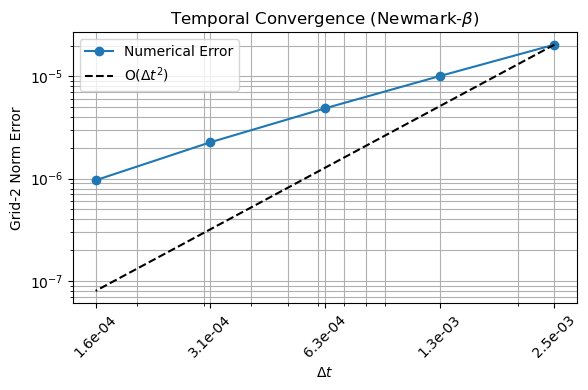

In [18]:
# Define physical & convergence parameters
L       = 1.0
c       = 1.0
t_final = 0.5

# Exact solution (matching initial amplitude of 0.03 m)
def exact_solution(x, t):
    return 0.03 * np.sin(np.pi * x / L) * np.cos(np.pi * c * t / L)

# Newmark-beta parameters
beta      = 1/4
gamma = 1/2

# Moderate spatial grid
n  = 200
x  = np.linspace(0, L, n+2)
dx = x[1] - x[0]

# Build finite-difference Laplacian D2
D2 = np.zeros((n+2, n+2))
for j in range(1, n+1):
    D2[j, j-1:j+2] = [1, -2, 1]
D2 *= c**2 / dx**2
D2[0, :] = D2[-1, :] = 0

# Sequence of N_t to test; tie dt to dx for each
Nt_list = [200, 400, 800, 1600, 3200]
errors   = []
dt_list  = []

for Nt in Nt_list:
    # Exact dt that divides t_final
    dt = t_final / Nt
    dt_list.append(dt)
    
    # Precompute effective matrix A_eff = I - beta * dt^2 * D2
    I     = np.eye(n+2)
    A_eff = I - beta * dt**2 * D2

    # Initialize u, v, a for Newmark-beta
    u = np.zeros((2, n+2))
    v = np.zeros((2, n+2))
    a = np.zeros((2, n+2))

    # Initial conditions
    u[0] = 0.03 * np.sin(np.pi * x / L)
    v[0] = 0.0
    a[0] = D2.dot(u[0])

    # Time stepping
    for _ in range(Nt):
        rhs   = u[0] + dt * v[0] + 0.5 * dt**2 * a[0]
        u[1]  = np.linalg.solve(A_eff, rhs)
        a[1]  = D2.dot(u[1])
        v[1]  = v[0] + dt * ((1 - gamma)*a[0] + gamma*a[1])
        # rotate buffers
        u[0], u[1] = u[1], u[0]
        v[0], v[1] = v[1], v[0]
        a[0], a[1] = a[1], a[0]

    # Compute grid-2 norm error at final time
    u_num = u[0]
    u_ex  = exact_solution(x, t_final)
    e_vec = u_num[1:-1] - u_ex[1:-1]
    errors.append(np.linalg.norm(e_vec) / np.sqrt(n))

# Print dt vs error
print("   Nt       dt         Error")
for Nt, dt, err in zip(Nt_list, dt_list, errors):
    print(f"{Nt:5d}  {dt:8.4e}  {err:8.4e}")

# Plot temporal convergence
plt.figure(figsize=(6,4))
plt.loglog(dt_list, errors, 'o-', label='Numerical Error')
ref = errors[0] * (np.array(dt_list)/dt_list[0])**2
plt.loglog(dt_list, ref, 'k--', label='O($\\Delta t^2$)')
# Optional: set custom x-ticks at each dt
plt.xticks(dt_list, [f"{dt:.1e}" for dt in dt_list], rotation=45)
plt.xlabel('$\\Delta t$')
plt.ylabel('Grid-2 Norm Error')
plt.title('Temporal Convergence (Newmark-$\\beta$)')
plt.grid(True, which='both')
plt.legend()
plt.tight_layout()
plt.show()

Looking at this plot, it seems that the temporal convergence is also slightly inaccurate to the analytical solution, though more accurate than the spatial convergence. Again, the errors are very small but not exact. We can clearly see that the error decreases as $\Delta t$ decreases, which is accurate. Although our numerical solutions did not converge perfectly with the analytical solution, we can conclude that the Newmark-$\beta$ method can be inaccurate with second-order functions and examples like our wave equation, which uses only one mode of vibration to represent the sine function of the string.